# Práctico 4

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import random
import functools
from scipy.stats import gamma


### Ejercicio 1

Genere un conjunto de 50 datos sintéticos $y_i = a+b ·x_i +\epsilon_i$ con ruido gaussiano, i.e. $\epsilon_i$ es una variable aleatoria que responde a una distribución $N(0, \sigma²)$.

 Utilice inferencia bayesiana para estimar a y b. Asuma prios planos y gaussianos.
 Obtenga la distribución posterior para ambos parámetros mediante MCMC.
 Compare con la solución analítica de la regresión lineal.

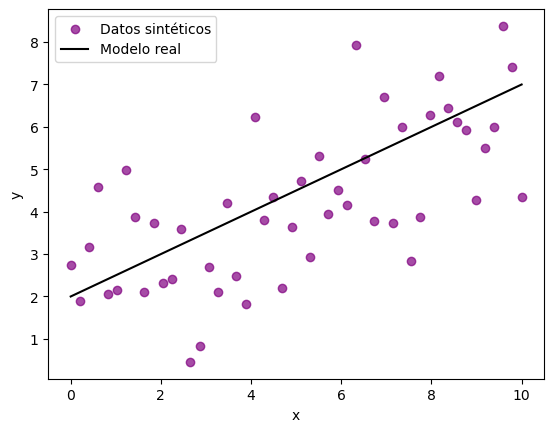

In [69]:
#Generar datos sintéticos

np.random.seed(42) #Fija la semilla del generador de números aleatorios.
N = 50
x = np.linspace(0, 10, N) #N valores de x entre 0 y 10
b_true, a_true = 2.0, 0.5
sigma = 1.5

y = b_true + a_true * x + np.random.normal(0, sigma, N)

plt.scatter(x, y, label="Datos sintéticos", color="purple", alpha=0.7) #crea un gráfico de dispersion con los datos sintéticos
plt.plot(x, b_true + a_true * x, label="Modelo real", color= "black") #Dibuja la recta verdadera
plt.legend() 
plt.xlabel("x"); plt.ylabel("y")
plt.savefig("lineal.pdf")
plt.show()



vamos a ajustarle unas rectas que definan los limites para los priors

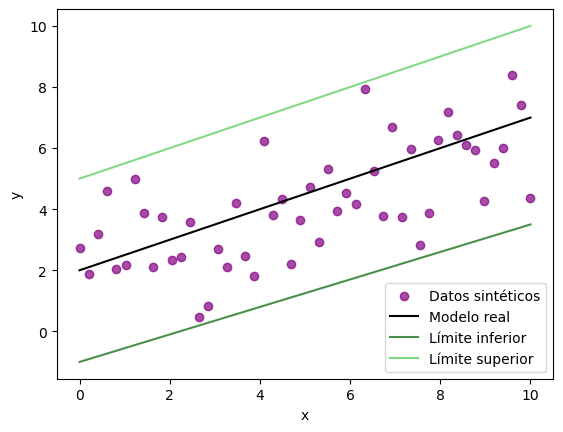

In [70]:
plt.scatter(x, y, label="Datos sintéticos", color="purple", alpha=0.7) #crea un gráfico de dispersion con los datos sintéticos
plt.plot(x, b_true + a_true * x, label="Modelo real",  color= "black") #Dibuja la recta verdadera
plt.plot(x, -1 + 0.45 * x, label="Límite inferior", color="#49914A")
plt.plot(x, 5 + 0.5 * x, label="Límite superior", color="#83DA86")
plt.legend(loc='lower right') 
plt.xlabel("x"); plt.ylabel("y")
plt.savefig("lineal_límites.pdf")
plt.show()


In [71]:

# Ajuste lineal
a_ls, b_ls = np.polyfit(x, y, 1)
print(f"b_LS = {b_ls:.3f}, a_LS = {a_ls:.3f}")
residuos = y - (b_ls + a_ls * x)
sigma_est = np.sqrt(np.sum(residuos**2) / (len(x) - 2))
print(f"Sigma estimado: {sigma_est:.3f}")


b_LS = 2.097, a_LS = 0.413
Sigma estimado: 1.391


In [72]:

def likelihood(b, a, x, y, sigma):
    model = b + a * x
    # Producto de gaussianas independientes
    L = np.prod(st.norm(loc=model, scale=sigma).pdf(y))
    return L

likelihood(x=x, y=y, b=2.0, a=0.5, sigma=1.5)

def prior_plano(b, a, a_min=-2, a_max=2, b_min=-1, b_max=5):
    if (a_min <= a <= a_max) and (b_min <= b <= b_max):
        return 1 / ((a_max - a_min) * (b_max - b_min))  # constante de normalización
    else:
        return 0.0

def prior_gaussiano(a, b, a_mean=0, a_sigma=1, b_mean=2, b_sigma=2):
    pa = st.norm(loc=a_mean, scale=a_sigma).pdf(a)
    pb = st.norm(loc=b_mean, scale=b_sigma).pdf(b)
    return pa * pb


def posterior(b, a, x, y, sigma, tipo_prior="plano"):
    if tipo_prior == "plano":
        prior = prior_plano(b, a)
    elif tipo_prior == "gaussiano":
        prior = prior_gaussiano(b, a)
    else:
        raise ValueError("tipo_prior debe ser 'plano' o 'gaussiano'")

    like = likelihood(b, a, x, y, sigma)
    return like * prior



In [73]:
# Metropolis-Hastings 

n_iter = 3000
a_chain = np.zeros(n_iter)
b_chain = np.zeros(n_iter)

# valores iniciales
a_chain[0], b_chain[0] = 0.0, 0.0
step_size = [0.1, 0.1]

for i in range(1, n_iter):
    b_current, a_current = b_chain[i-1], a_chain[i-1]

    # Propuesta gaussiana
    a_prop = np.random.normal(a_current, step_size[0])
    b_prop = np.random.normal(b_current, step_size[1])

    # Posteriores 
    p_current = posterior(b_current, a_current, x, y, sigma)
    p_proposed = posterior(b_prop, a_prop, x, y, sigma)

    # Cociente de aceptación 
    if p_current == 0:
        alpha = 1
    else:
        alpha = min(1, p_proposed / p_current)

    # Aceptar o rechazar
    if np.random.rand() < alpha:
        b_chain[i], a_chain[i] = b_prop, a_prop
    else:
        b_chain[i], a_chain[i] = b_current, a_current




Valor medio a = 0.444 ± 0.074
Valor medio b = 1.865 ± 0.435


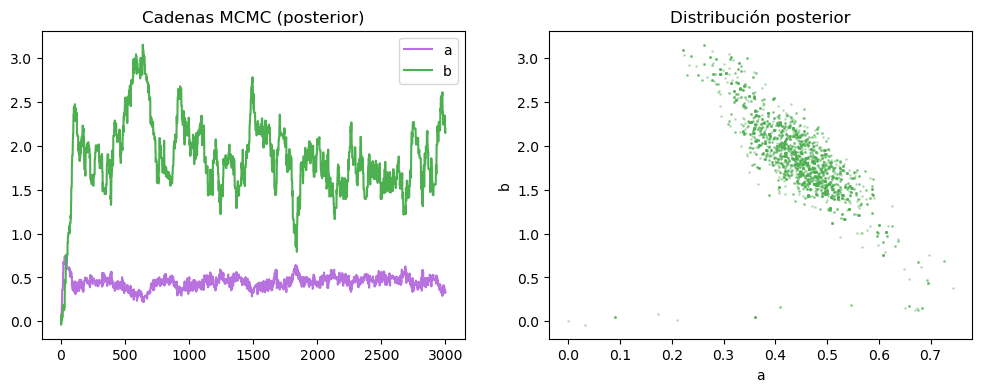

Solución analítica: a = 2.097, b = 0.413


In [74]:
# Analizar resultados

a_samples = a_chain
b_samples = b_chain

print(f"Valor medio a = {np.mean(a_samples):.3f} ± {np.std(a_samples):.3f}")
print(f"Valor medio b = {np.mean(b_samples):.3f} ± {np.std(b_samples):.3f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(a_samples, label='a', color="#B872E0")
plt.plot(b_samples, label='b', color="#4CAF50")
plt.legend(); plt.title("Cadenas MCMC (posterior)")
plt.subplot(1,2,2)
plt.scatter(a_samples, b_samples, s=1, alpha=0.3, color="#4CAF50")
plt.xlabel("a"); plt.ylabel("b")
plt.title("Distribución posterior")
plt.savefig("cadenas_lineal.pdf")
plt.show()

# ---------- Paso 5. Comparar con regresión lineal clásica ----------
A = np.vstack([np.ones_like(x), x]).T
a_ls, b_ls = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"Solución analítica: a = {a_ls:.3f}, b = {b_ls:.3f}")

### Ejercicio 2
Leer y graficar los datos pertenecientes a la función de luminosidad de galaxias obtenida por Blanton et al. (2001). Donde los datos correspondientes a la función de luminosidad se encuentran en el aula virtual.

In [75]:
filename = "/home/regi/Escritorio/astrometriaI/astrometria2025/tp4/datos_Blanton.csv"

In [76]:
x,y,e1,e2 = np.genfromtxt(filename, delimiter=',', unpack=True, skip_header=1) #e1<e2

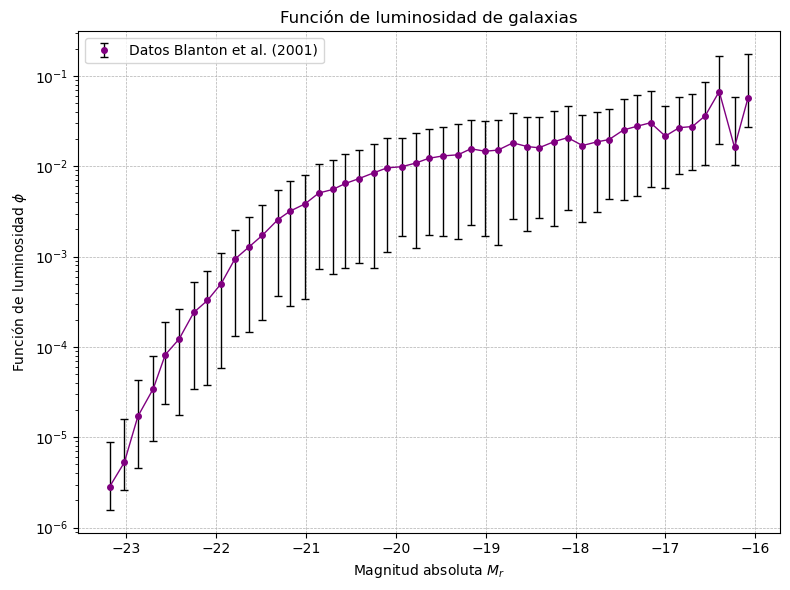

In [77]:
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=[e1, e2], fmt='o', color="purple" , ecolor='black', markersize=4 ,  elinewidth=1, capsize=3, label='Datos Blanton et al. (2001)')
plt.plot(x, y, color="purple" , linestyle='-', linewidth=1)
plt.yscale('log')
plt.xlabel('Magnitud absoluta $M_r$')
plt.ylabel(r'Función de luminosidad $\phi$')
plt.title('Función de luminosidad de galaxias')
plt.legend()
plt.grid(True, which="major", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig("sche.pdf")
plt.show()

### Ejercicio 3

Se desea ajustar el modelo m al conjunto de datos $d$, mediante un análisis Bayesiano. Para el caso de los datos del Ej. 2, se utilizará como modelo la función de Schechter:

$\Phi(M)dM = 0.4 ln(10)\Phi∗ 10^{−0.4(M−M∗)(\alpha+1)} exp(−10^{−0.4(M−M∗)}) dM$

Los parámetros que se intentan determinar son $\Phi∗$, $M∗$ y $\alpha$. Para ello, escribir en python la función de likelihood, de priorsm, y de probabilidad posterior.
Estas funciones se necesitarrán cuando se explore el espacio de par ́ametros. Determine claramente
los parámetros de entrada y de salida de estas funciones e impleméntelas en un programa.

In [78]:
#Se define una función que represente el modelo de Schechter

def sche(phi0, M0, a, M):
    
    phi1 = []
    for i in range(len(M)):
        
        b = -0.4*(M[i]-M0)*(a+1)
        c = -0.4*(M[i]-M0)
        phi = 0.4 * math.log(10) * phi0 * 10**b * math.exp(-10**c)
        phi1.append(phi) #Se almacena el valor de phi en una lista.
    
    return np.array(phi1)



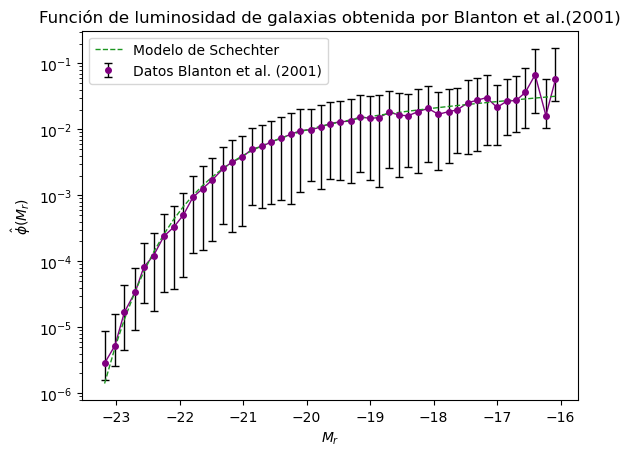

In [79]:
#Se grafica el modelo sobre los puntos para verificar la función modelo

plt.title('Función de luminosidad de galaxias obtenida por Blanton et al.(2001)')
plt.xlabel('$M_{r}$')
plt.ylabel(r'$\hat \phi(M_{r})$')
plt.yscale('log')
plt.yscale('log')
plt.errorbar(x, y, yerr=[e1, e2], fmt='o', color='purple', ecolor='black', markersize=4 ,  elinewidth=1, capsize=3, label=r'Datos Blanton et al. (2001)')
plt.plot(x, y, color='purple', linestyle='-', linewidth=1)
phi_model1 = sche(1.46E-2, -20.83, -1.20, x) 
plt.plot(x, phi_model1, color="#1D9621", linestyle='--', linewidth=1, label=r'Modelo de Schechter')
plt.legend()
plt.savefig("sche_ajuste.pdf")
plt.show()


Los parámetros que se intentan determinar son $\Phi∗$, $M∗$ y $\alpha$. Para ello, se propgraman las funciones likelihood, priors, y de probabilidad posterior.

In [80]:
#Se calcula el sigma de los datos, usando las barras de error
s= np.abs(e1 - e2)/2


def likelihood(x, y, phi0, M0, a, sig):
    
    phi_model = sche(phi0,M0,a,x) #phi_model es un array con los valores esperados de phi
    p = st.norm(loc=phi_model, scale=sig).pdf(y) #p es un array con las probabilidades de cada punto
    #El likelihood es el producto de las probabilidades individuales
    l = p.prod()
    return(l)


likelihood(x=x, y=y, phi0=1.46E-2,M0=-20.83,a=-1.20,sig=s)
#Con los valores de los parámetros de Blanton el likelihood es muy grande
#Los datos reproducen bien las predicciones del modelo


np.float64(2.4805431942310263e+121)

Los priors son la información previa que se tiene sobre el modelo. Si se supone que no se conoce nada del modelo, entonces se usan priors donde todos los valores en cierto rango tienen la misma probabilidad.
En este caso, se buscará estimar los valores límite de los parámetros del modelo variando los parámetros y observando gráficamente.

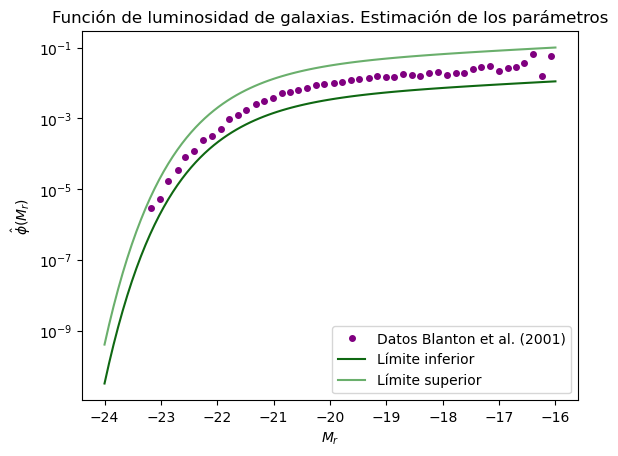

In [81]:
#promediod e las magntiudes= -18.39
#promedio de phi= 1.51E-2

M1 = np.linspace(-24, -16, 100) #crea un array con 200 valores equiespaciados entre –24 y –16.

y1 = sche(phi0=0.5E-2,M0=-20.85,a=-1.20,M=M1)
y2 = sche(phi0=4.5E-2,M0=-20.87,a=-1.2,M=M1)

plt.title(r'Función de luminosidad de galaxias. Estimación de los parámetros')
plt.xlabel(r'$M_{r}$')
plt.ylabel(r'$\hat \phi(M_{r})$')
plt.yscale('log')
plt.plot(x, y, 'o', color='purple', markersize=4, label = r'Datos Blanton et al. (2001)')
plt.plot(M1,y1, label = 'Límite inferior', color="#0F6812")
plt.plot(M1,y2, label = 'Límite superior', color="#6AAF6C")
plt.legend(loc='lower right')
plt.savefig("sche_límites.pdf")
plt.show()


In [82]:
#Se define la función prior con distribución uniforme en un rango determinado para cada parámetro.
def prior(phi, m, a,
          phi0_inf=0.5e-2, phi0_sup=4.5e-2,
          m0_inf=-22, m0_sup=-19,
          a_inf=-1.9, a_sup=-0.001):
    # uniforme por soporte explícito (devuelve densidad)
    if not (phi0_inf < phi < phi0_sup and m0_inf < m < m0_sup and a_inf < a < a_sup):
        return 0.0
    # densidad uniforme independiente = 1/width_prod
    width_prod = (phi0_sup - phi0_inf) * (m0_sup - m0_inf) * (a_sup - a_inf)
    return 1.0 / width_prod

#Se define la función posterior usando el likelihood y el prior definidos anteriormente.

def post(x, y, phi0, m0, a, sig):
    
    post= likelihood(x,y,phi0,m0,a,sig) * prior(phi0, m0, a)
    return(post)

Estas funciones se necesitarán cuando se explore el espacio de parámetros. Determine claramente los parámetros de entrada y de salida de estas funciones e impleméntelas en un programa. Explicite las hipétesis que intervienen en este planteo (especialmente respecto de los errores), la motivación de dichas hipótesis y las simplificaciones que se consiguen. Utilizando estas funciones, implementar un algoritmo de Metrópolis-Hastings para explorar el espacio de parámetros. Los parámetros del algoritmo son el largo de la cadena (un némero entero) y las funciones prior. Tener en cuenta que los priors contienen el conocimiento previo sobre los datos. Los priors más comunes son funciones planas y funciones gaussianas.
Explicar qué parámetros intervienen, cómo y por qué se eligen sus valores. Experimentar con distintas funciones de prior y evaluar su impacto en la realización de las cadenas.

In [96]:
step_phi = 0.001
step_m0  = 0.1
step_a   = 0.01

"""La distribución proposal genera una propuesta de nuevos valores de los parámetros 
a partir de los actuales. Se usa una distribución normal centrada en el valor anterior y con las desviaciones elegidas.
"""
def proposal(theta):
    phi0, m0, a = theta
    phi_new = np.random.normal(phi0, step_phi)
    m0_new  = np.random.normal(m0, step_m0)
    a_new   = np.random.normal(a, step_a)
    return [phi_new, m0_new, a_new]


posterior = 0                   #Se define una variable posterior y se la inicializa en cero.
while posterior < 1.E-8:        # Se inicia la cadena dentro de los valores permitidos para los parámetros
                                
    phi0_inicial = random.uniform(0.5E-2, 4.5E-2) #Se generan valores iniciales aleatorios
    m0_inicial = random.uniform(-22, -19)
    a0_inicial = random.uniform(-1.9, -0.001)
    
    
    posterior = post(x, y, phi0 = phi0_inicial, m0 = m0_inicial, a = a0_inicial, sig = s)


cadena_phi0 = []
cadena_m0 = []
cadena_a0 = []

N = 30000

for i in range(N):
    
    phi0_new, m0_new, a0_new = proposal([phi0_inicial, m0_inicial, a0_inicial])
    
    posterior_new = post(x, y, phi0_new, m0_new, a0_new, sig=s)
    
    prob_aceptacion = min(1, posterior_new / posterior)
    
    r = random.random()
    acepto = r < prob_aceptacion #para uno de los casos siempre se cumple para el otro a veces
    
    if acepto:
        
        phi0_inicial = phi0_new
        m0_inicial = m0_new
        a0_inicial = a0_new
        posterior = posterior_new
   
    cadena_phi0.append(phi0_inicial)
    cadena_m0.append(m0_inicial)
    cadena_a0.append(a0_inicial)


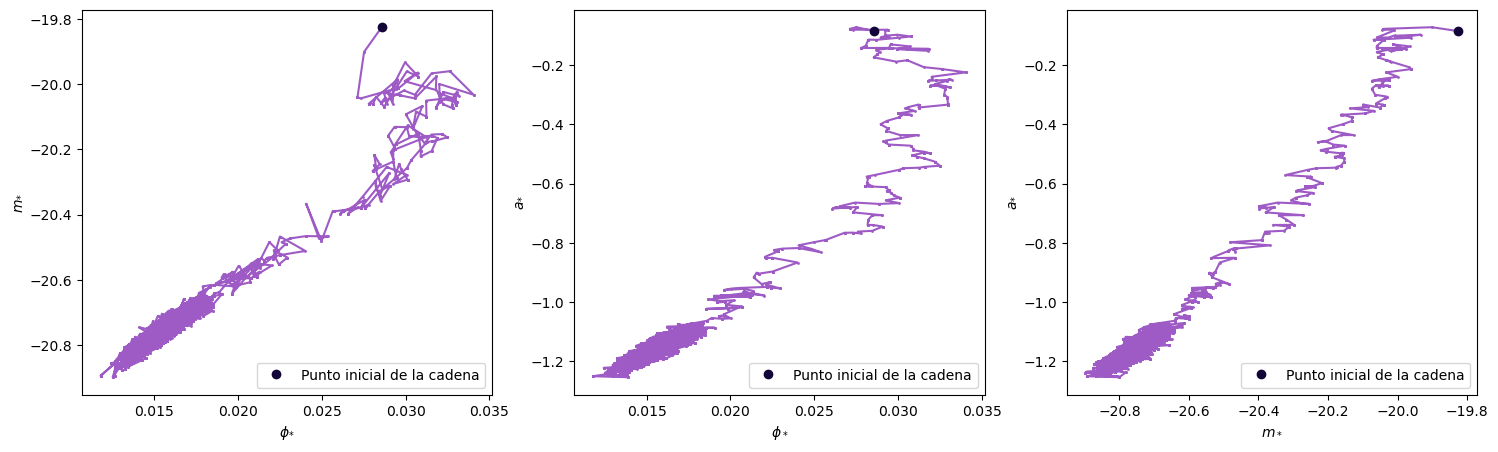

In [97]:
#Se grafican los parámetros 

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(cadena_phi0, cadena_m0, marker='.',markersize=2 ,color = "#9E5BC5" )
plt.plot(cadena_phi0[0], cadena_m0[0], 'o', color = "#120538", label='Punto inicial de la cadena') 
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$m_{*}$')

plt.subplot(1,3,2)
plt.plot(cadena_phi0, cadena_a0, marker='.',markersize=2 ,color = "#9E5BC5")
plt.plot(cadena_phi0[0], cadena_a0[0], 'o', color = "#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$a_{*}$')

plt.subplot(1,3,3)
plt.plot(cadena_m0, cadena_a0, marker='.',markersize=2 ,color = "#9E5BC5")
plt.plot(cadena_m0[0], cadena_a0[0], 'o', color = "#120538",label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$m_*$')
plt.ylabel(r'$a_{*}$')

plt.show()


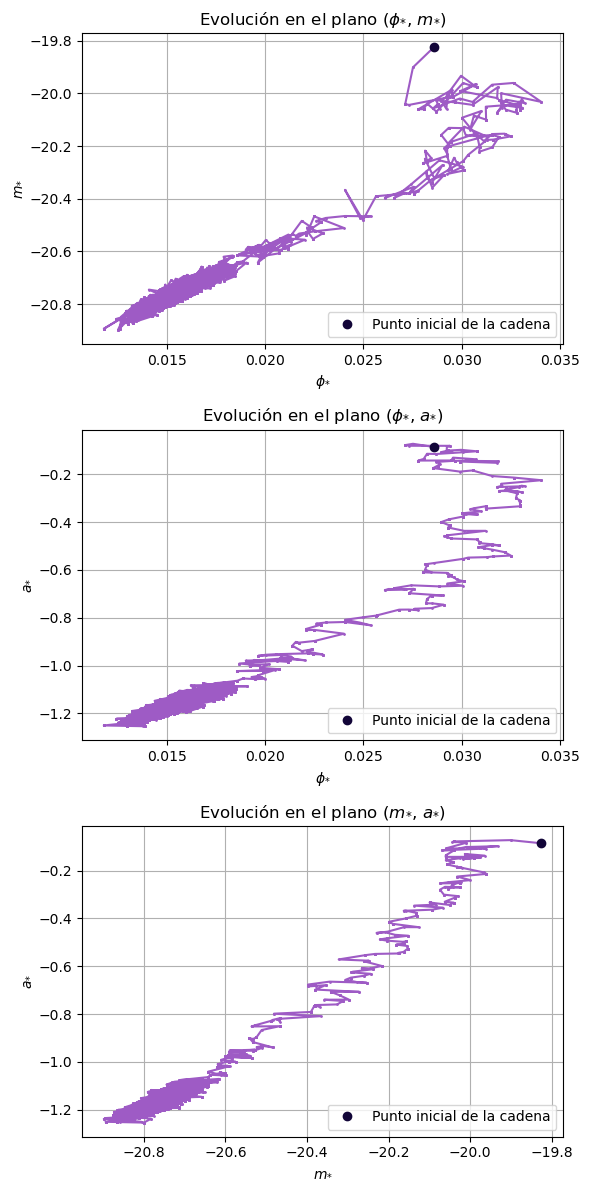

In [98]:
# Se grafican los parámetros en disposición vertical

plt.figure(figsize=(6, 12))  # más alto que ancho

# --- Gráfico 1: φ* vs m* ---
plt.subplot(3, 1, 1)
plt.plot(cadena_phi0, cadena_m0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_phi0[0], cadena_m0[0], 'o', color="#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$m_{*}$')
plt.title(r'Evolución en el plano ($\phi_{*}$, $m_{*}$)')
plt.grid(True)

# --- Gráfico 2: φ* vs a* ---
plt.subplot(3, 1, 2)
plt.plot(cadena_phi0, cadena_a0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_phi0[0], cadena_a0[0], 'o', color="#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$a_{*}$')
plt.title(r'Evolución en el plano ($\phi_{*}$, $a_{*}$)')
plt.grid(True)

# --- Gráfico 3: m* vs a* ---
plt.subplot(3, 1, 3)
plt.plot(cadena_m0, cadena_a0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_m0[0], cadena_a0[0], 'o', color="#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$m_{*}$')
plt.ylabel(r'$a_{*}$')
plt.title(r'Evolución en el plano ($m_{*}$, $a_{*}$)')
plt.grid(True)

plt.tight_layout()
plt.savefig("sche_caminos_lineal.pdf")
plt.show()


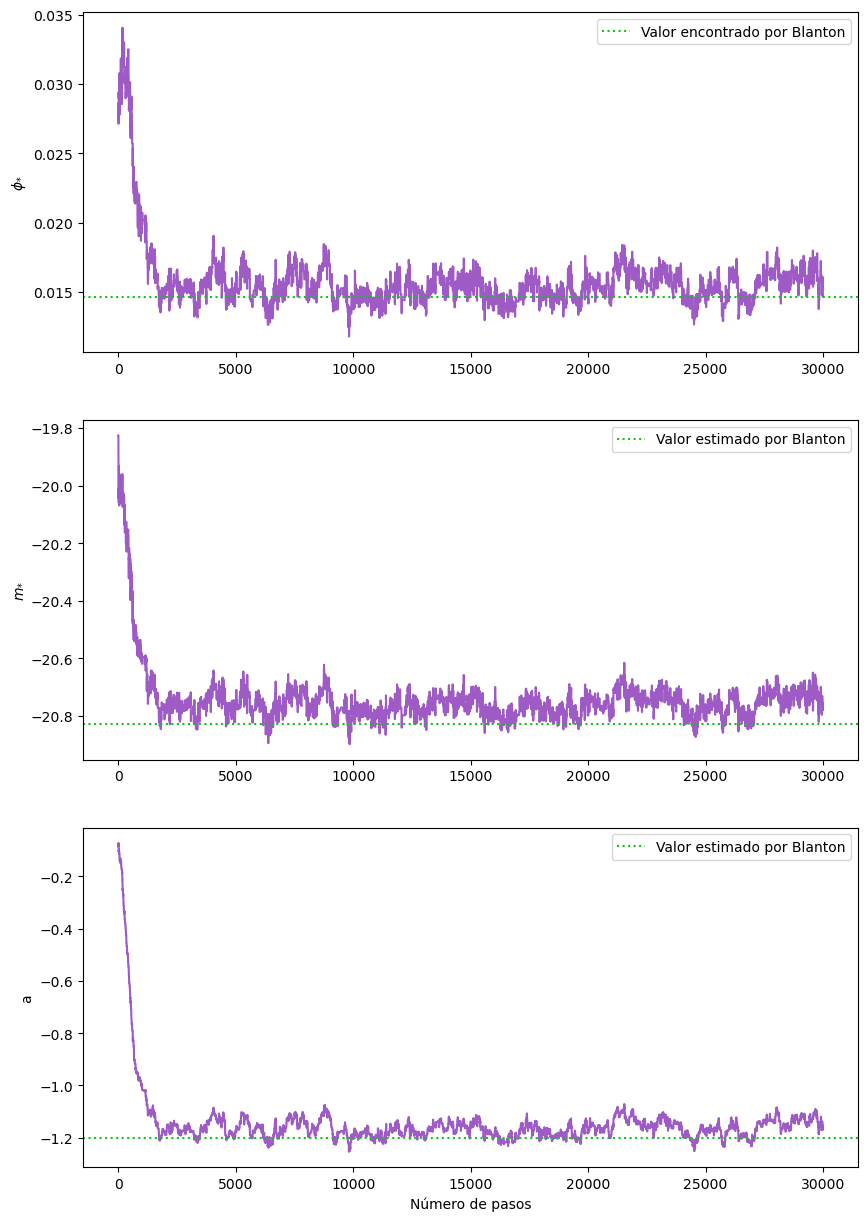

In [99]:
#Se grafica 
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(cadena_phi0, color= "#9E5BC5")
plt.axhline(0.0146, color="#14C21A", label=r'Valor encontrado por Blanton', ls="dotted") 
plt.legend(loc='upper right')
plt.ylabel(r'$\phi_{*}$')

plt.subplot(3,1,2)
plt.plot(cadena_m0, color = "#9E5BC5")
plt.axhline(-20.83, color="#14C21A", label=r'Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel(r'$m_{*}$')

plt.subplot(3,1,3)
plt.plot(cadena_a0, color = "#9E5BC5")
plt.axhline(-1.2, color= "#14C21A", label=r'Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('a')
plt.savefig("sche_lineal_iteraciones.pdf")
plt.savefig("sche_lineal_iteraciones.pdf")
plt.show()



veamos que pasa si elegimos un prior gaussiano

In [104]:
def prior_gauss(phi, m, a,
          phi0_mean=1.46e-2, phi0_sigma=0.005e-2,
          M0_mean=-20.83, M0_sigma=0.5,
          a_mean=-1.20, a_sigma=0.2):
    p_phi = st.norm.pdf(phi, loc=phi0_mean, scale=phi0_sigma)
    p_M0  = st.norm.pdf(m,   loc=M0_mean,  scale=M0_sigma)
    p_a   = st.norm.pdf(a,   loc=a_mean,   scale=a_sigma)
    return p_phi * p_M0 * p_a

def post_gauss(x, y, phi0, m0, a, sig):
    
    post_gauss= likelihood(x,y,phi0,m0,a,sig) * prior_gauss(phi0, m0, a)
    return(post_gauss)


step_phi = 0.001
step_m0  = 0.1
step_a   = 0.01

"""La distribución proposal genera una propuesta de nuevos valores de los parámetros 
a partir de los actuales. Se usa una distribución normal centrada en el valor anterior y con las desviaciones elegidas.
"""
def proposal(theta):
    phi0, m0, a = theta
    phi_new = np.random.normal(phi0, step_phi)
    m0_new  = np.random.normal(m0, step_m0)
    a_new   = np.random.normal(a, step_a)
    return [phi_new, m0_new, a_new]


posterior_g = 0                   #Se define una variable posterior y se la inicializa en cero.
while posterior_g < 1.E-8:        # Se inicia la cadena dentro de los valores permitidos para los parámetros
                                
    phi0_inicial = random.uniform(0.5E-2, 4.5E-2) #Se generan valores iniciales aleatorios
    m0_inicial = random.uniform(-22, -19)
    a0_inicial = random.uniform(-1.9, -0.001)
    
    
    posterior_g = post_gauss(x, y, phi0 = phi0_inicial, m0 = m0_inicial, a = a0_inicial, sig = s)


cadena_phi0 = []
cadena_m0 = []
cadena_a0 = []

N = 30000

for i in range(N):
    
    phi0_new, m0_new, a0_new = proposal([phi0_inicial, m0_inicial, a0_inicial])
    
    posterior_new = post_gauss(x, y, phi0_new, m0_new, a0_new, sig=s)
    
    prob_aceptacion = min(1, posterior_new / posterior_g)
    
    r = random.random()
    acepto = r < prob_aceptacion #para uno de los casos siempre se cumple para el otro a veces
    
    if acepto:
        
        phi0_inicial = phi0_new
        m0_inicial = m0_new
        a0_inicial = a0_new
        posterior_g = posterior_new
   
    cadena_phi0.append(phi0_inicial)
    cadena_m0.append(m0_inicial)
    cadena_a0.append(a0_inicial)



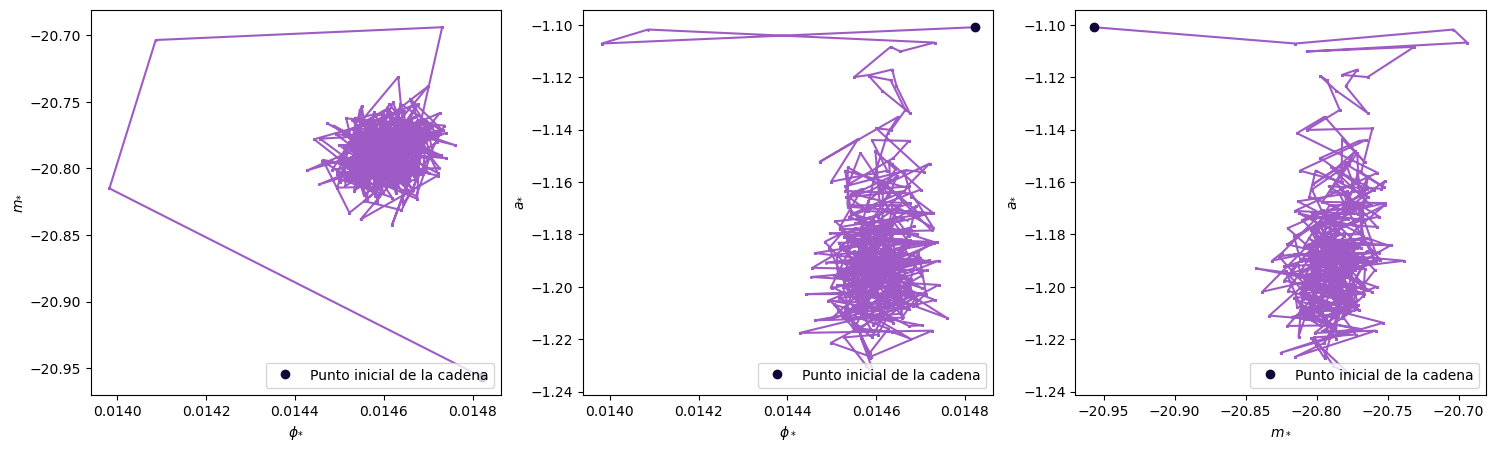

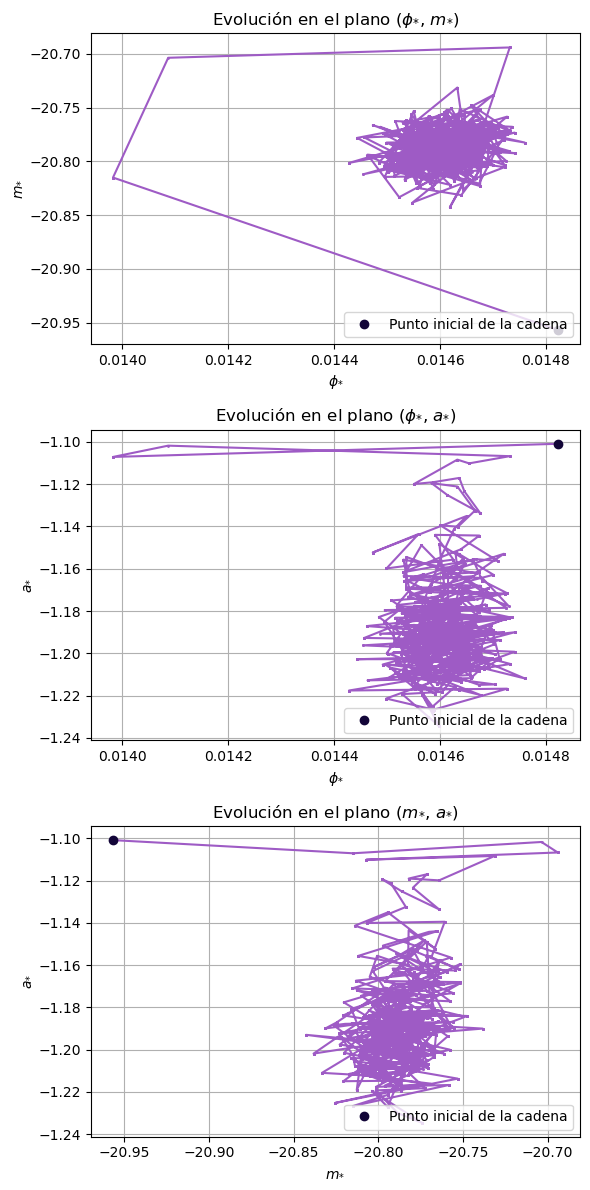

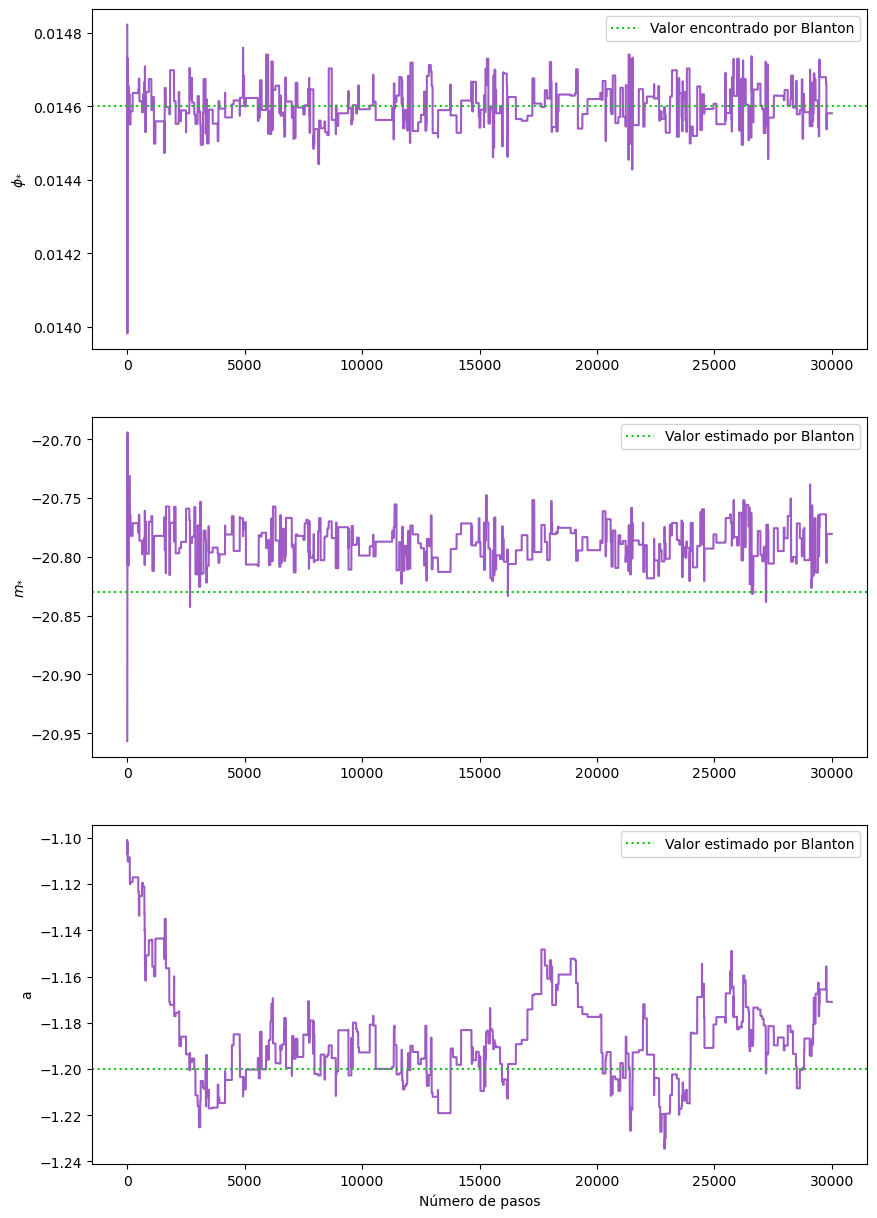

In [106]:


plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(cadena_phi0, cadena_m0, marker='.',markersize=2 ,color = "#9E5BC5")
plt.plot(cadena_phi0[0], cadena_m0[0], 'o', color = "#120538", label='Punto inicial de la cadena') 
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$m_{*}$')

plt.subplot(1,3,2)
plt.plot(cadena_phi0, cadena_a0, marker='.',markersize=2 ,color = "#9E5BC5")
plt.plot(cadena_phi0[0], cadena_a0[0], 'o', color = "#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$a_{*}$')

plt.subplot(1,3,3)
plt.plot(cadena_m0, cadena_a0, marker='.',markersize=2 ,color = "#9E5BC5")
plt.plot(cadena_m0[0], cadena_a0[0], 'o', color = "#120538",label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$m_*$')
plt.ylabel(r'$a_{*}$')

plt.show()

plt.figure(figsize=(6, 12))  # más alto y angosto para disposición vertical

# --- Gráfico 1: φ* vs M* ---
plt.subplot(3, 1, 1)
plt.plot(cadena_phi0, cadena_m0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_phi0[0], cadena_m0[0], 'o', color="#120538", label='Punto inicial de la cadena') 
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$m_{*}$')
plt.title(r'Evolución en el plano ($\phi_{*}$, $m_{*}$)')
plt.grid(True)

# --- Gráfico 2: φ* vs a* ---
plt.subplot(3, 1, 2)
plt.plot(cadena_phi0, cadena_a0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_phi0[0], cadena_a0[0], 'o', color="#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$a_{*}$')
plt.title(r'Evolución en el plano ($\phi_{*}$, $a_{*}$)')
plt.grid(True)

# --- Gráfico 3: m* vs a* ---
plt.subplot(3, 1, 3)
plt.plot(cadena_m0, cadena_a0, marker='.', markersize=2, color="#9E5BC5")
plt.plot(cadena_m0[0], cadena_a0[0], 'o', color="#120538", label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel(r'$m_{*}$')
plt.ylabel(r'$a_{*}$')
plt.title(r'Evolución en el plano ($m_{*}$, $a_{*}$)')
plt.grid(True)

plt.tight_layout()
plt.savefig("sche_gauss_caminos.pdf")
plt.show()


#Se grafica 
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(cadena_phi0, color= "#9E5BC5")
plt.axhline(0.0146, color="#14C21A", label=r'Valor encontrado por Blanton', ls="dotted") 
plt.legend(loc='upper right')
plt.ylabel(r'$\phi_{*}$')

plt.subplot(3,1,2)
plt.plot(cadena_m0, color = "#9E5BC5")
plt.axhline(-20.83, color="#14C21A", label=r'Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel(r'$m_{*}$')

plt.subplot(3,1,3)
plt.plot(cadena_a0, color = "#9E5BC5")
plt.axhline(-1.2, color="#14C21A", label=r'Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('a')
plt.savefig("sche_gauss_iteraciones.pdf")
plt.show()


### Ejercicio 4
Visualizar las propiedades de convergencia de las cadenas. Encontrar condiciones de la simulación
para las cuales se produce un mal y un buen mezclado de las cadenas. Para ello realize varias
cadenas y compárelas.
    Se pueden realizar los siguietes gráficos:
 - Likelihood vs valor de un parámetro
 - Valor de un parámetro vs eslabón de la cadena
 - Distribución marginal de los valores de un parémetro (en este caso tener en cuenta que la cadena sea “estable”)
 - Curvas de nivel de la función de Likelihood.
 - Máxima separación entre cadenas como funcián del número de pasos. Para esto es necesario contar
con varias cadenas independientes, inicializadas con posiciones aleatorias de acuerdo a los priors

In [107]:
import numpy as np
import random
from scipy import stats as st

# --- Likelihood logarítmico ---
def log_likelihood(x, y, phi0, M0, a, sig):
    phi_model = np.array(sche(phi0, M0, a, x))
    ll = np.sum(st.norm(loc=phi_model, scale=sig).logpdf(y))
    return ll

# --- Prior gaussiano logarítmico ---
def log_prior_gauss(phi, m, a,
                    phi0_mean=1.46e-2, phi0_sigma=0.005e-2,
                    M0_mean=-20.83, M0_sigma=0.5,
                    a_mean=-1.20, a_sigma=0.2):
    lp_phi = st.norm.logpdf(phi, loc=phi0_mean, scale=phi0_sigma)
    lp_M0  = st.norm.logpdf(m,   loc=M0_mean,  scale=M0_sigma)
    lp_a   = st.norm.logpdf(a,   loc=a_mean,   scale=a_sigma)
    return lp_phi + lp_M0 + lp_a

# --- Posterior logarítmico ---
def log_post_gauss(x, y, phi0, m0, a, sig):
    return log_likelihood(x, y, phi0, m0, a, sig) + log_prior_gauss(phi0, m0, a)

# --- Distribución de propuesta ---
step_phi = 0.001
step_m0  = 0.1
step_a   = 0.1

def proposal(theta):
    phi0, m0, a = theta
    phi_new = np.random.normal(phi0, step_phi)
    m0_new  = np.random.normal(m0, step_m0)
    a_new   = np.random.normal(a, step_a)
    return [phi_new, m0_new, a_new]

# --- Número de cadenas y pasos ---
n_cadenas = 4
Npasos = 5000  # pasos por cadena

cadenas = []

for c in range(n_cadenas):
    # Inicialización aleatoria dentro del prior
    phi0_inicial = random.uniform(0.5E-2, 4.5E-2)
    m0_inicial = random.uniform(-22, -19)
    a0_inicial = random.uniform(-1.9, -0.001)
    
    posterior_g = log_post_gauss(x, y, phi0_inicial, m0_inicial, a0_inicial, sig=s)
    
    cadena_phi0 = []
    cadena_m0 = []
    cadena_a0 = []
    
    for i in range(Npasos):
        phi0_new, m0_new, a0_new = proposal([phi0_inicial, m0_inicial, a0_inicial])
        posterior_new = log_post_gauss(x, y, phi0_new, m0_new, a0_new, sig=s)
        
        # Aceptación usando log-posterior
        prob_aceptacion = min(1, np.exp(posterior_new - posterior_g))
        
        if random.random() < prob_aceptacion:
            phi0_inicial, m0_inicial, a0_inicial = phi0_new, m0_new, a0_new
            posterior_g = posterior_new
        
        cadena_phi0.append(phi0_inicial)
        cadena_m0.append(m0_inicial)
        cadena_a0.append(a0_inicial)
    
    # Guardar la cadena en la lista de cadenas
    cadenas.append({
        "phi0": np.array(cadena_phi0),
        "m0": np.array(cadena_m0),
        "a": np.array(cadena_a0)
    })


/tmp/ipykernel_12124/1555486975.py:60: RuntimeWarning: overflow encountered in exp
  prob_aceptacion = min(1, np.exp(posterior_new - posterior_g))


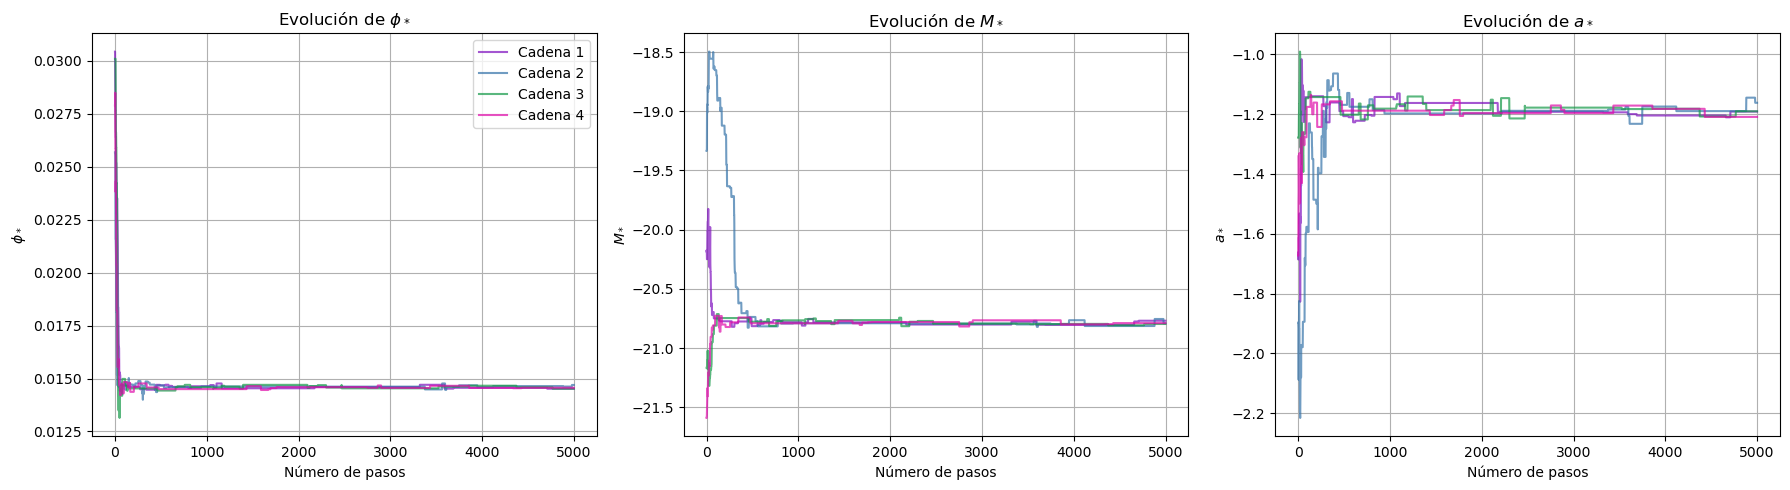

In [108]:
colores = ["#7E0FBE", "#3472A8", "#149947", "#DF0AA9"]  # colores distintos para cada cadena
parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

plt.figure(figsize=(18, 5))

for i, param in enumerate(parametros):
    plt.subplot(1, 3, i+1)
    for c in range(n_cadenas):
        plt.plot(cadenas[c][param], color=colores[c], alpha=0.7, label=f'Cadena {c+1}')
    plt.xlabel('Número de pasos')
    plt.ylabel(titulos[i])
    plt.title(f'Evolución de {titulos[i]}')
    plt.grid(True)
    if i == 0:
        plt.legend(loc='best')

plt.tight_layout()
plt.show()


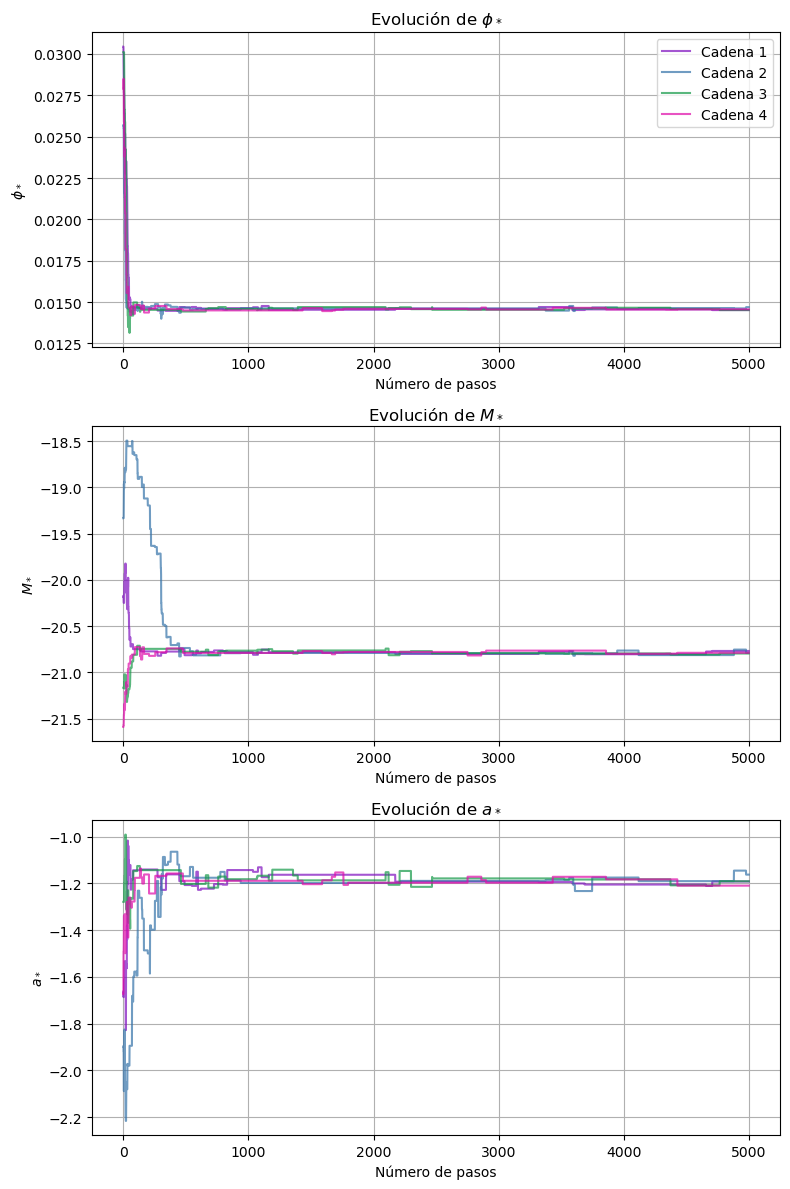

In [109]:
colores = ["#7E0FBE", "#3472A8", "#149947", "#DF0AA9"]  # colores distintos para cada cadena
parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

plt.figure(figsize=(8, 12))  # más alto para acomodar los tres gráficos verticalmente

for i, param in enumerate(parametros):
    plt.subplot(3, 1, i+1)  # (3 filas, 1 columna, índice i+1)
    for c in range(n_cadenas):
        plt.plot(cadenas[c][param], color=colores[c], alpha=0.7, label=f'Cadena {c+1}')
    plt.xlabel('Número de pasos')
    plt.ylabel(titulos[i])
    plt.title(f'Evolución de {titulos[i]}')
    plt.grid(True)
    if i == 0:
        plt.legend(loc='best')

plt.tight_layout()
plt.savefig("sche_4cadenas_pasos.pdf")
plt.show()


/tmp/ipykernel_12124/752415296.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


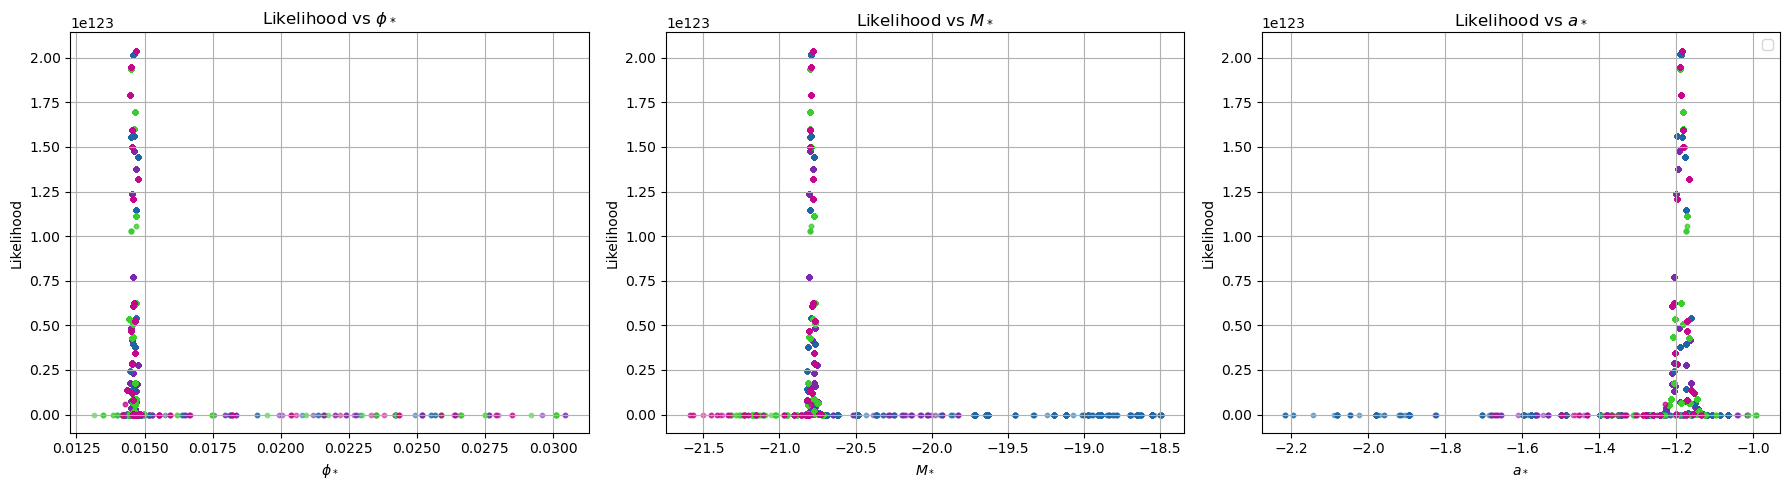

In [110]:
colores = ["#7B28AC", '#1D65A5', "#3BCC2E", "#C5078C"]  # colores para cada cadena
parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

plt.figure(figsize=(18,5))

for i, param in enumerate(parametros):
    plt.subplot(1, 3, i+1)
    
    for c in range(n_cadenas):
        # Extraer la cadena actual
        cadena = cadenas[c]
        # Calcular likelihood para cada paso variando solo el parámetro de interés
        ll_vals = []
        for j in range(len(cadena[param])):
            phi_val = cadena['phi0'][j] if param != 'phi0' else cadena[param][j]
            m_val   = cadena['m0'][j]  if param != 'm0'   else cadena[param][j]
            a_val   = cadena['a'][j]   if param != 'a'    else cadena[param][j]
            # Evaluamos likelihood usando los valores de los demás parámetros de ese paso
            ll = np.exp(log_likelihood(x, y, phi_val, m_val, a_val, s))
            ll_vals.append(ll)
        
        plt.scatter(cadena[param], ll_vals, color=colores[c], alpha=0.5, s=10, label=f'Cadena {c+1}' if i==0 else "")
    
    plt.xlabel(titulos[i])
    plt.ylabel('Likelihood')
    plt.title(f'Likelihood vs {titulos[i]}')
    plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_12124/734572573.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


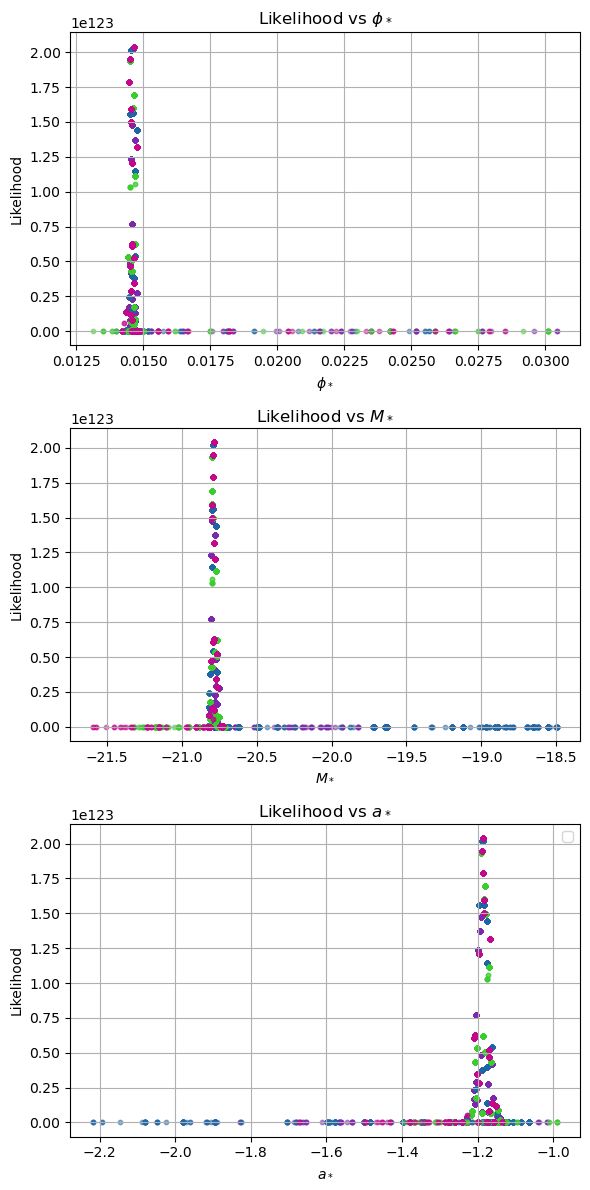

In [111]:
colores = ["#7B28AC", '#1D65A5', "#3BCC2E", "#C5078C"]  # colores para cada cadena
parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

plt.figure(figsize=(6,12))

for i, param in enumerate(parametros):
    plt.subplot(3, 1, i+1)  # <--- disposición vertical
    
    for c in range(n_cadenas):
        cadena = cadenas[c]
        ll_vals = []
        for j in range(len(cadena[param])):
            phi_val = cadena['phi0'][j] if param != 'phi0' else cadena[param][j]
            m_val   = cadena['m0'][j]  if param != 'm0'   else cadena[param][j]
            a_val   = cadena['a'][j]   if param != 'a'    else cadena[param][j]
            ll = np.exp(log_likelihood(x, y, phi_val, m_val, a_val, s))
            ll_vals.append(ll)
        
        plt.scatter(cadena[param], ll_vals, color=colores[c], alpha=0.5, s=10, label=f'Cadena {c+1}' if i==0 else "")
    
    plt.xlabel(titulos[i])
    plt.ylabel('Likelihood')
    plt.title(f'Likelihood vs {titulos[i]}')
    plt.grid(True)

plt.legend()
plt.tight_layout()
plt.savefig("sche_4cadenas_likelihood.pdf")
plt.show()


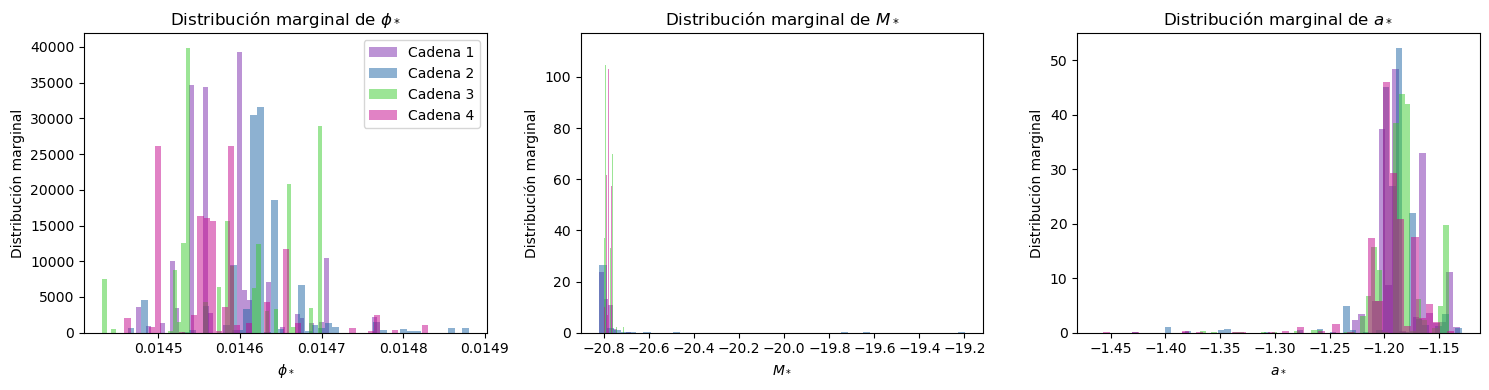

In [112]:
plt.figure(figsize=(15,4))

parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

for i, param in enumerate(parametros):
    plt.subplot(1, 3, i+1)
    
    # Combinar todas las cadenas para calcular percentiles globales
    todos_los_vals = np.concatenate([cadenas[c][param] for c in range(n_cadenas)])
    lower, upper = np.percentile(todos_los_vals, [1, 99])
    
    for c in range(n_cadenas):
        cadena_vals = cadenas[c][param]
        # Recortar usando los límites globales
        cadena_recortada = cadena_vals[(cadena_vals >= lower) & (cadena_vals <= upper)]
        
        plt.hist(cadena_recortada, bins=50, density=True, alpha=0.5, color=colores[c], label=f'Cadena {c+1}')
    
    plt.xlabel(titulos[i])
    plt.ylabel('Distribución marginal')
    plt.title(f'Distribución marginal de {titulos[i]}')
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()



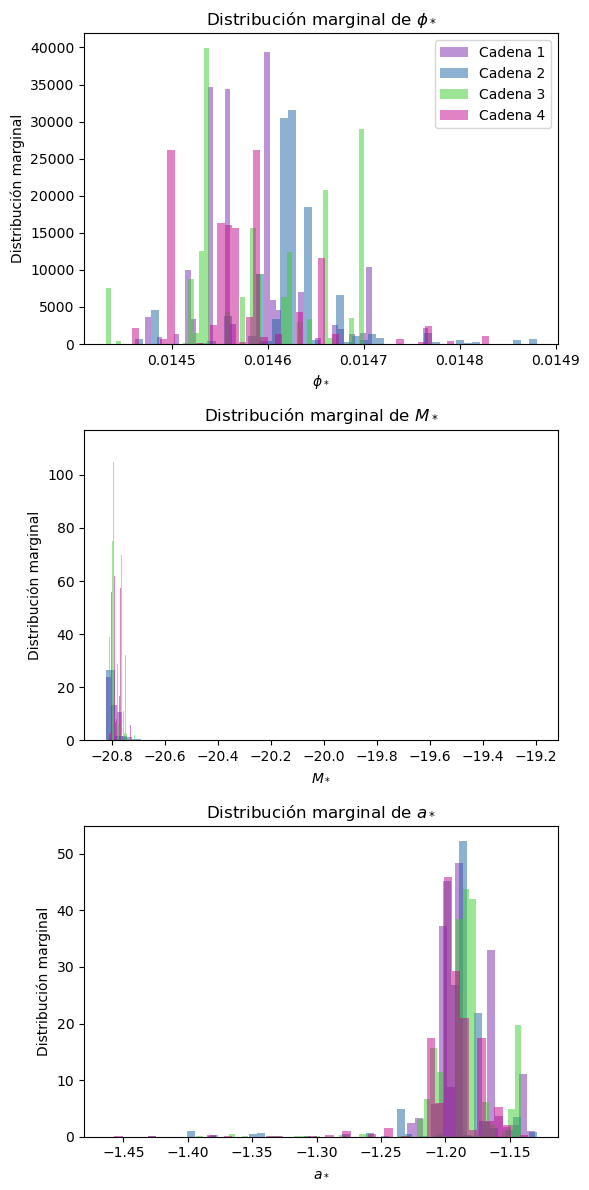

In [113]:
plt.figure(figsize=(6,12))  # más alto, más angosto

parametros = ['phi0', 'm0', 'a']
titulos = [r'$\phi_*$', r'$M_*$', r'$a_*$']

for i, param in enumerate(parametros):
    plt.subplot(3, 1, i+1)  # disposición vertical
    
    # Combinar todas las cadenas para calcular percentiles globales
    todos_los_vals = np.concatenate([cadenas[c][param] for c in range(n_cadenas)])
    lower, upper = np.percentile(todos_los_vals, [1, 99])
    
    for c in range(n_cadenas):
        cadena_vals = cadenas[c][param]
        # Recortar usando los límites globales
        cadena_recortada = cadena_vals[(cadena_vals >= lower) & (cadena_vals <= upper)]
        
        plt.hist(cadena_recortada, bins=50, density=True, alpha=0.5, color=colores[c], label=f'Cadena {c+1}')
    
    plt.xlabel(titulos[i])
    plt.ylabel('Distribución marginal')
    plt.title(f'Distribución marginal de {titulos[i]}')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("sche_4cadenas_distr_marg.pdf")
plt.show()


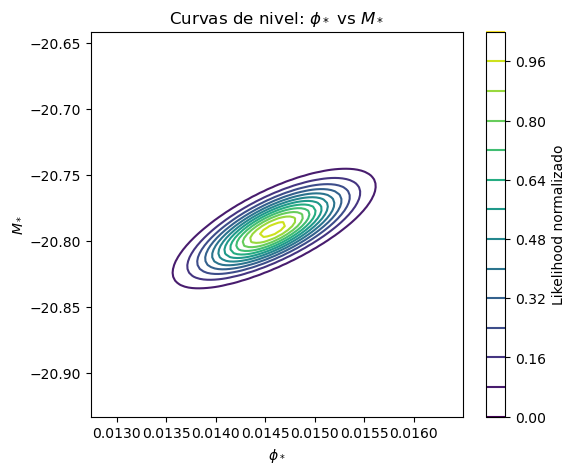

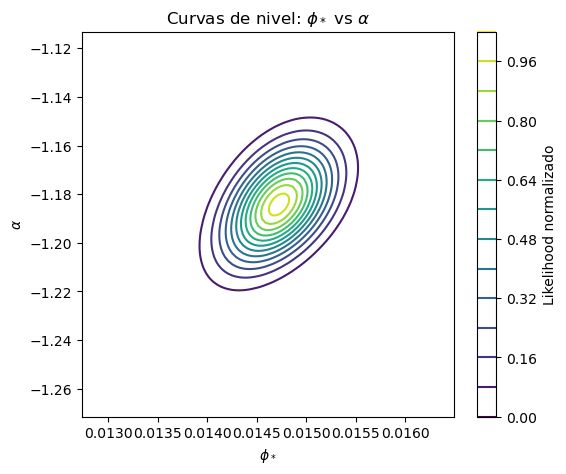

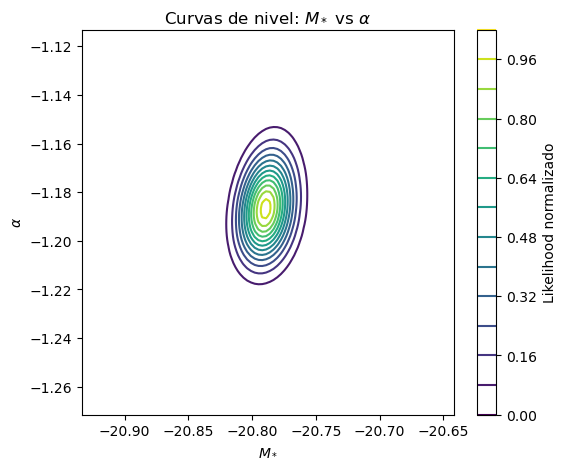

In [ ]:
# Promedios y desviaciones de las cadenas
phi_mean, phi_std = np.mean(cadena_phi0), np.std(cadena_phi0)
M_mean, M_std     = np.mean(cadena_m0), np.std(cadena_m0)
a_mean, a_std     = np.mean(cadena_a0), np.std(cadena_a0)

# Número de puntos en la malla
Ngrid = 100

# -----------------------------
# 1) phi_* vs M_* (alpha fijo)
# -----------------------------
phi_vals = np.linspace(phi_mean - 3*phi_std, phi_mean + 3*phi_std, Ngrid)
M_vals   = np.linspace(M_mean - 3*M_std, M_mean + 3*M_std, Ngrid)
Phi, M = np.meshgrid(phi_vals, M_vals)

logL = np.zeros_like(Phi)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, Phi[i,j], M[i,j], a_mean, s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.figure(figsize=(6,5))
cont = plt.contour(Phi, M, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$M_*$')
plt.title(r'Curvas de nivel: $\phi_*$ vs $M_*$')
plt.colorbar(cont, label='Likelihood normalizado')
plt.show()


# -----------------------------
# 2) phi_* vs alpha (M_* fijo)
# -----------------------------
phi_vals = np.linspace(phi_mean - 3*phi_std, phi_mean + 3*phi_std, Ngrid)
a_vals   = np.linspace(a_mean - 3*a_std, a_mean + 3*a_std, Ngrid)
Phi, A = np.meshgrid(phi_vals, a_vals)

logL = np.zeros_like(Phi)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, Phi[i,j], M_mean, A[i,j], s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.figure(figsize=(6,5))
cont = plt.contour(Phi, A, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$\alpha$')
plt.title(r'Curvas de nivel: $\phi_*$ vs $\alpha$')
plt.colorbar(cont, label='Likelihood normalizado')
plt.show()


# -----------------------------
# 3) M_* vs alpha (phi_* fijo)
# -----------------------------
M_vals   = np.linspace(M_mean - 3*M_std, M_mean + 3*M_std, Ngrid)
a_vals   = np.linspace(a_mean - 3*a_std, a_mean + 3*a_std, Ngrid)
M, A = np.meshgrid(M_vals, a_vals)

logL = np.zeros_like(M)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, phi_mean, M[i,j], A[i,j], s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.figure(figsize=(6,5))
cont = plt.contour(M, A, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$M_*$')
plt.ylabel(r'$\alpha$')
plt.title(r'Curvas de nivel: $M_*$ vs $\alpha$')
plt.colorbar(cont, label='Likelihood normalizado')
plt.show()


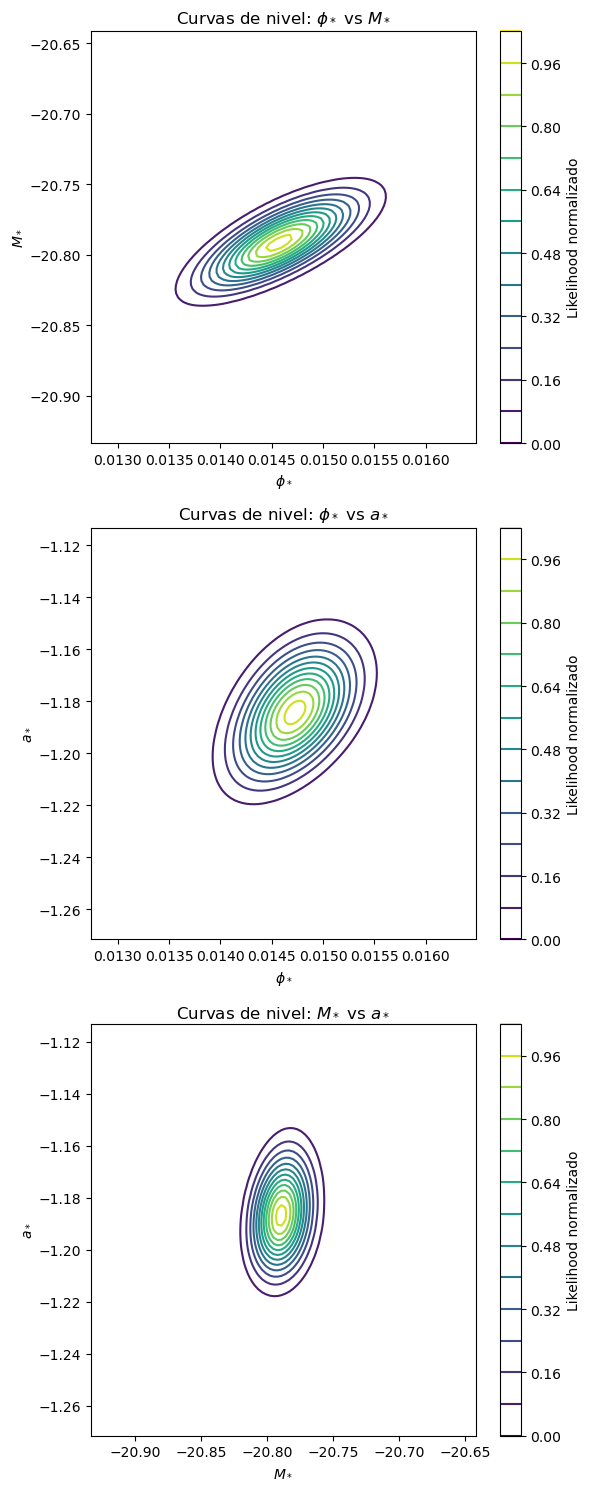

In [116]:
# Promedios y desviaciones de las cadenas
phi_mean, phi_std = np.mean(cadena_phi0), np.std(cadena_phi0)
M_mean, M_std     = np.mean(cadena_m0), np.std(cadena_m0)
a_mean, a_std     = np.mean(cadena_a0), np.std(cadena_a0)

# Número de puntos en la malla
Ngrid = 100

plt.figure(figsize=(6,15))  # más alto, disposición vertical

# -----------------------------
# 1) phi_* vs M_* (a fijo)
# -----------------------------
phi_vals = np.linspace(phi_mean - 3*phi_std, phi_mean + 3*phi_std, Ngrid)
M_vals   = np.linspace(M_mean - 3*M_std, M_mean + 3*M_std, Ngrid)
Phi, M = np.meshgrid(phi_vals, M_vals)

logL = np.zeros_like(Phi)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, Phi[i,j], M[i,j], a_mean, s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.subplot(3,1,1)
cont = plt.contour(Phi, M, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$M_*$')
plt.title(r'Curvas de nivel: $\phi_*$ vs $M_*$')
plt.colorbar(cont, label='Likelihood normalizado')

# -----------------------------
# 2) phi_* vs a (M_* fijo)
# -----------------------------
phi_vals = np.linspace(phi_mean - 3*phi_std, phi_mean + 3*phi_std, Ngrid)
a_vals   = np.linspace(a_mean - 3*a_std, a_mean + 3*a_std, Ngrid)
Phi, A = np.meshgrid(phi_vals, a_vals)

logL = np.zeros_like(Phi)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, Phi[i,j], M_mean, A[i,j], s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.subplot(3,1,2)
cont = plt.contour(Phi, A, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$\phi_*$')
plt.ylabel(r'$a_*$')
plt.title(r'Curvas de nivel: $\phi_*$ vs $a_*$')
plt.colorbar(cont, label='Likelihood normalizado')

# -----------------------------
# 3) M_* vs a (phi_* fijo)
# -----------------------------
M_vals   = np.linspace(M_mean - 3*M_std, M_mean + 3*M_std, Ngrid)
a_vals   = np.linspace(a_mean - 3*a_std, a_mean + 3*a_std, Ngrid)
M, A = np.meshgrid(M_vals, a_vals)

logL = np.zeros_like(M)
for i in range(Ngrid):
    for j in range(Ngrid):
        logL[i,j] = log_likelihood(x, y, phi_mean, M[i,j], A[i,j], s)

logL_max = np.max(logL)
L_norm = np.exp(logL - logL_max)

plt.subplot(3,1,3)
cont = plt.contour(M, A, L_norm, levels=15, cmap='viridis')
plt.xlabel(r'$M_*$')
plt.ylabel(r'$a_*$')
plt.title(r'Curvas de nivel: $M_*$ vs $a_*$')
plt.colorbar(cont, label='Likelihood normalizado')

plt.tight_layout()
plt.savefig("sche_curvas_nivel.pdf")
plt.show()


### Ejercicio 6
Implemente el método de gradiente descendente para encontrar el mínimo de Likelihood marginalizado
a cada uno de los parámetros. Discuta posibles cuestiones de precisión, conveniencias e inconveniencias
del método.

In [117]:
def chi(x, y, phi0, M0, a, s):
    model = sche(phi0, M0, a, x)
    return np.sum(((y - model) / s) ** 2)

In [118]:
def d_sche_phi0(phi0, M0, a, M):
    
    dsphi1 = []
    for i in range(len(M)):
        
        b = -0.4*(M[i]-M0)*(a+1)
        c = -0.4*(M[i]-M0)
        dmphi = 0.4 * math.log(10) * 10**b * math.exp(-10**c)
        dsphi1.append(dmphi)
    
    return(dsphi1)    

#Se define la derivada del modelo respecto del parámetro m0

def d_sche_M0(phi0, M0, a, M):
    dsM01 = []
    for i in range(len(M)):

        f = 10**(-0.4*(M[i]-M0)*(a+1))
        g = math.exp(-10**(-0.4*(M[i]-M0)))
        
        df = f * 0.4 * math.log(10) * (a+1)
        dg = -g * 0.4 * math.log(10) * 10**(-0.4 * (M[i]-M0))
        
        dmM0 = 0.4 *math.log(10)* phi0 * (df * g + f * dg)
        dsM01.append(dmM0)
        
    return dsM01

#Se define la derivada del modelo respecto del parámetro alpha

def d_sche_a(phi0, M0, a, M):
    
    dsa1 = []
    for i in range(len(M)):
     
        f = 10**(-0.4*(M[i]-M0)*(a+1))
        df = f * -0.4*math.log(10)*(M[i]-M0)
        g = math.exp(-10**(-0.4*(M[i]-M0)))
        dma = 0.4* math.log(10)*phi0 * df * g  
        dsa1.append(dma)
    return(dsa1)



In [119]:
def Gradiente_Chi2(x, y, phi0, M0, a, sigma = s):
    dchi2_phi0 = 0.0
    dchi2_m0 = 0.0
    dchi2_a = 0.0

    model_pars = sche(phi0, M0, a, x)
    dfmodel_phi0 = d_sche_phi0(phi0, M0, a, M = x)
    dfmodel_m0 = d_sche_M0(phi0, M0, a, M = x)
    dfmodel_a0 = d_sche_a(phi0, M0, a, M = x)

    for j in range(len(x)):
        resid = (y[j] - model_pars[j])
        w = 1.0 / (sigma[j] ** 2)
        dchi2_phi0 += -2.0 * resid * w * dfmodel_phi0[j]
        dchi2_m0   += -2.0 * resid * w * dfmodel_m0[j]
        dchi2_a    += -2.0 * resid * w * dfmodel_a0[j]

    return np.array([dchi2_phi0, dchi2_m0, dchi2_a])



<>:96: SyntaxWarning: invalid escape sequence '\c'
<>:96: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_12124/2599114247.py:96: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Evolución de $\chi^2$ con iteraciones')


Resultados finales del Gradiente Descendente:
  φ₀ final = 1.511936e-02
  M₀ final = -20.771025
  a  final = -1.173136
  χ² final = 20.540714


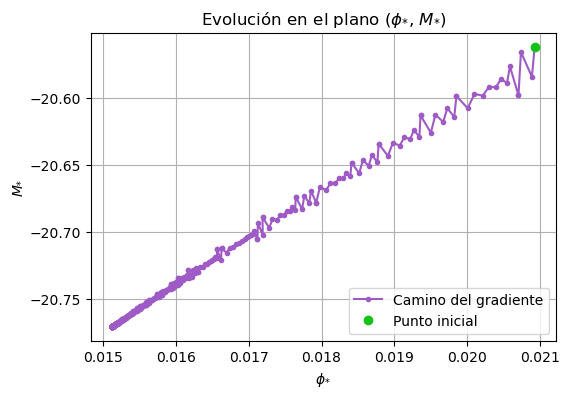

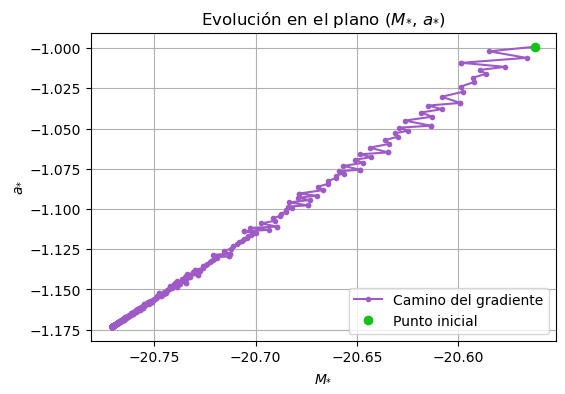

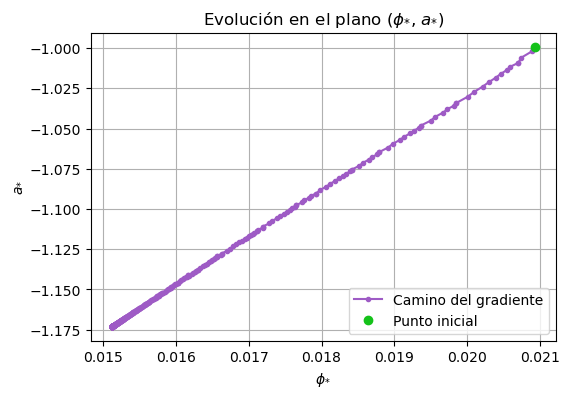

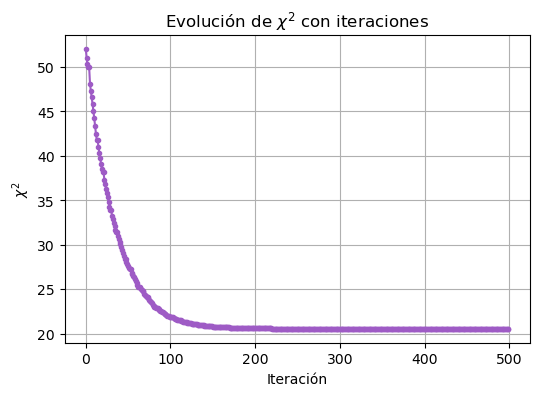

In [121]:
def Gradiente_descendente(x, y, n_inicial, N_pasos, s):
    
    # Inicialización de parámetros
    grad = np.array([0,0,0])
    while np.any(grad < (1.E-8)):
        phi0 = random.uniform(0.005, 0.025)
        M0 = random.uniform(-21.0, -20.5)
        a = random.uniform(-1.5, -0.9)
        grad = Gradiente_Chi2(x, y, phi0, M0, a, s)
    
    camino_phi0 = [phi0]
    camino_m0 = [M0]
    camino_a = [a]
    chi2_hist = [chi(x, y, phi0, M0, a, s)]

    n = n_inicial  # paso inicial
    for i in range(1, N_pasos):
        # Guardamos los valores previos
        chi2_actual = chi2_hist[-1]
        
        # Paso tentativa
        phi0_new = phi0 - n * grad[0] * 1e-6
        M0_new   = M0   - n * grad[1] * 1e-2
        a_new    = a    - n * grad[2] * 1e-3
        
        chi2_nuevo = chi(x, y, phi0_new, M0_new, a_new, s)
        
        # --- Line search ---
        if chi2_nuevo < chi2_actual:
            # Mejoró → aumentar un poco n
            n *= 1.1
            phi0, M0, a = phi0_new, M0_new, a_new
        else:
            # Empeoró → retroceder y reducir n
            n *= 0.5
        
        grad = Gradiente_Chi2(x, y, phi0, M0, a, s)
        
        camino_phi0.append(phi0)
        camino_m0.append(M0)
        camino_a.append(a)
        chi2_hist.append(chi(x, y, phi0, M0, a, s))
        
    return camino_phi0, camino_m0, camino_a, chi2_hist


# --- Ejecución ---
g1_phi, g1_M0, g1_a, chi2_hist = Gradiente_descendente(x, y, n_inicial=0.02, N_pasos=500, s=s)

phi0_final = g1_phi[-1]
m0_final   = g1_M0[-1]
a0_final   = g1_a[-1]
chi2_final = chi2_hist[-1]

print("Resultados finales del Gradiente Descendente:")
print(f"  φ₀ final = {phi0_final:.6e}")
print(f"  M₀ final = {m0_final:.6f}")
print(f"  a  final = {a0_final:.6f}")
print(f"  χ² final = {chi2_final:.6f}")



# --- Gráficos de trayectoria de parámetros ---
plt.figure(figsize=(6,4))
plt.plot(g1_phi, g1_M0, marker='.', color= "#9E5BC5" , label='Camino del gradiente')
plt.plot(g1_phi[0], g1_M0[0], 'o', color="#14C21A", label='Punto inicial')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$M_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($\phi_{*}$, $M_{*}$)')
plt.grid(True)

plt.figure(figsize=(6,4))
plt.plot(g1_M0, g1_a, marker='.', color= "#9E5BC5", label='Camino del gradiente')
plt.plot(g1_M0[0], g1_a[0], 'o',color="#14C21A", label='Punto inicial')
plt.xlabel(r'$M_{*}$')
plt.ylabel(r'$a_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($M_{*}$, $a_{*}$)')
plt.grid(True)

plt.figure(figsize=(6,4))
plt.plot(g1_phi, g1_a, marker='.', color= "#9E5BC5", label='Camino del gradiente')
plt.plot(g1_phi[0], g1_a[0], 'o',color="#14C21A", label='Punto inicial')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$a_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($\phi_{*}$, $a_{*}$)')
plt.grid(True)

# --- Gráfico de chi² ---
plt.figure(figsize=(6,4))
plt.plot(chi2_hist, color= "#9E5BC5", marker='.')
plt.xlabel('Iteración')
plt.ylabel(r'$\chi^2$')
plt.title('Evolución de $\chi^2$ con iteraciones')
plt.grid(True)
plt.savefig("chi2.pdf")
plt.show()

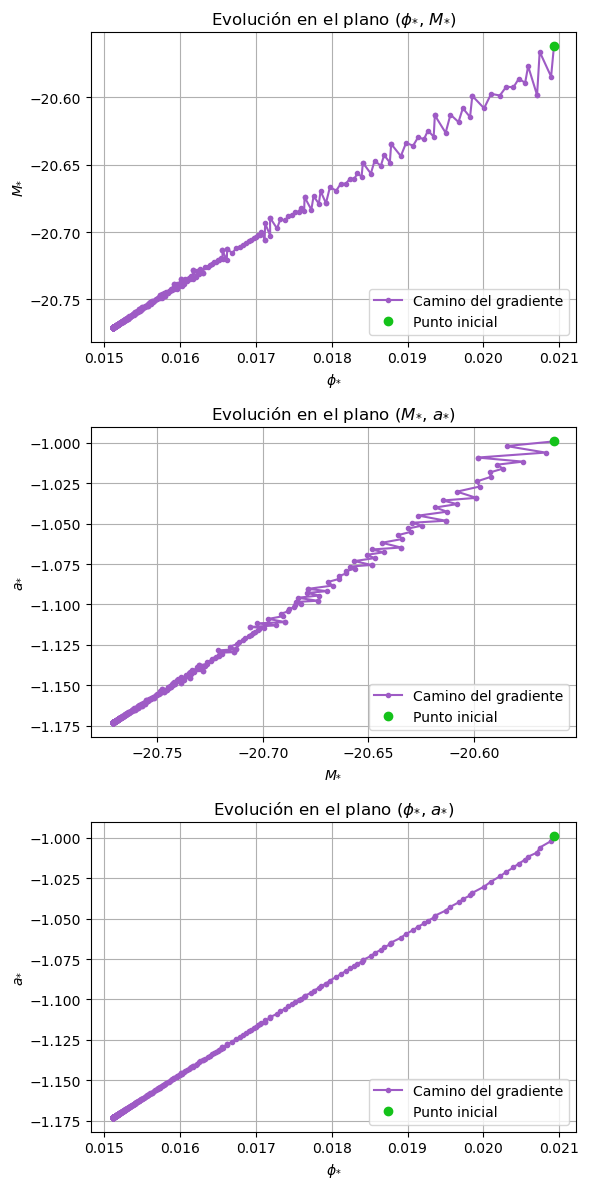

In [122]:
# --- Gráficos de trayectoria de parámetros (verticales) ---
plt.figure(figsize=(6, 12))  # alto para 3 subplots verticales

# 1) phi_* vs M_*
plt.subplot(3,1,1)
plt.plot(g1_phi, g1_M0, marker='.', color="#9E5BC5", label='Camino del gradiente')
plt.plot(g1_phi[0], g1_M0[0], 'o', color="#14C21A", label='Punto inicial')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$M_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($\phi_{*}$, $M_{*}$)')
plt.grid(True)

# 2) M_* vs a_*
plt.subplot(3,1,2)
plt.plot(g1_M0, g1_a, marker='.', color="#9E5BC5", label='Camino del gradiente')
plt.plot(g1_M0[0], g1_a[0], 'o', color="#14C21A", label='Punto inicial')
plt.xlabel(r'$M_{*}$')
plt.ylabel(r'$a_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($M_{*}$, $a_{*}$)')
plt.grid(True)

# 3) phi_* vs a_*
plt.subplot(3,1,3)
plt.plot(g1_phi, g1_a, marker='.', color="#9E5BC5", label='Camino del gradiente')
plt.plot(g1_phi[0], g1_a[0], 'o', color="#14C21A", label='Punto inicial')
plt.xlabel(r'$\phi_{*}$')
plt.ylabel(r'$a_{*}$')
plt.legend(loc='lower right')
plt.title(r'Evolución en el plano ($\phi_{*}$, $a_{*}$)')
plt.grid(True)

plt.tight_layout()
plt.savefig("gradiente_evolución.pdf")
plt.show()


### Ejercicio 8: Teorema de Bayes
Suponga que posee una moneda cargada, y desea determinar su sesgo (p) a partir datos (i.e., la cantidad de caras y secas observadas en un experimento). Para ello, arroja la moneda 100 veces, obteniéndose 60 caras y 40 secas.
- Escriba una función de Python que compute la probabilidad posteriori de p (la probabilidad de obtener cara) utilizando un prior uniforme.
- Compute el Likelihood de obtener los datos registrados
- Realice un gráfico de la distribuci ́on posteriori de p.
- Ahora asuma un prior gaussino con media 0.5 y desviación estándar 0.1 y recompute la probabilidad posteriori.
- Compare como se ve afectada la distribución posteriori según la elección del prior.

MAP con prior uniforme: p = 0.600
MAP con prior gaussiano: p = 0.581


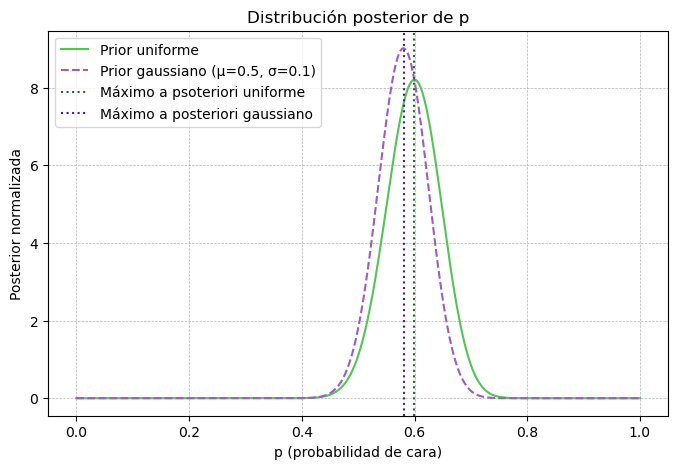

In [124]:
caras = 60
secas = 40
N = caras + secas

p = np.linspace(0, 1, 1000) # 1000 valores de p entre 0 y 1

def likelihood(p, caras, secas):
    like = []
    for pi in p:
        if pi == 0 or pi == 1:
            like.append(0)
        else:
            like.append((pi**caras) * ((1 - pi)**secas))
    return np.array(like)

def prior_c(p):
    return np.ones(len(p))  # constante

def prior_g(p, mu=0.5, sigma=0.1):
    gauss = []
    for pi in p:
        val = math.exp(-0.5 * ((pi - mu)/sigma)**2)
        gauss.append(val)
    return np.array(gauss)

def posterior(p, caras, secas, prior_func):
    L = likelihood(p, caras, secas)
    Pr = prior_func(p)
    post = L * Pr
    post = post / np.trapezoid(post, p) #normalizar el área total a 1 
    return post

posterior_c = posterior(p, caras, secas, prior_c)

posterior_g = posterior(p, caras, secas, prior_g)

# --- Calcular el valor máximo de la posterior (MAP) ---
p_map_c = p[np.argmax(posterior_c)]
p_map_g = p[np.argmax(posterior_g)]

print(f"MAP con prior uniforme: p = {p_map_c:.3f}")
print(f"MAP con prior gaussiano: p = {p_map_g:.3f}")

#graficamos

plt.figure(figsize=(8,5))
plt.plot(p, posterior_c, label='Prior uniforme', color="#53C556")
plt.plot(p, posterior_g, label='Prior gaussiano (μ=0.5, σ=0.1)',  color= "#9E5BC5", ls='--')
plt.axvline(p_map_c,  color="#1D6E20", ls=':', lw=1.5, label="Máximo a psoteriori uniforme")
plt.axvline(p_map_g,  color= "#541D74", ls=':', lw=1.5, label="Máximo a posteriori gaussiano")
plt.xlabel('p (probabilidad de cara)')
plt.ylabel('Posterior normalizada')
plt.title('Distribución posterior de p')
plt.legend()
plt.grid(True, ls='--', lw=0.5)
plt.savefig("caras.pdf")
plt.show()

### Ejercicio 9: Frecuentistas vs Bayesianos
Supóngase que se mide el tiempo de decaimiento de una partícula, el cual es modelado como una función exponencial con constante de decaimiento $\lambda$.
- Simule 50 mediciones del tiempo de decaimiento
- Estime $\lambda$ utilizando el estimador de Maximum Likelihood
- Estime $\lambda$ utilizando inferencia Bayesiana asumiendo un prior plano
- Compare las dos estimaciones

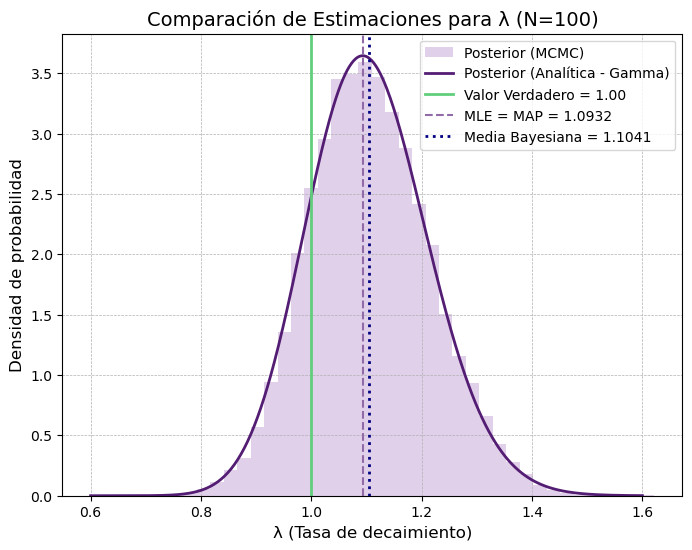

In [125]:
lam_real = 1.0
N = 100

np.random.seed(42)
t = np.random.exponential(1/lam_real, N)


lam_MLE = N / np.sum(t)

# p(lambda | datos) ~ lambda^N * exp(-lambda * sum(t))
alpha_post = N + 1
beta_post = np.sum(t)

# Distribución posterior analítica (Gamma)
lam_grid = np.linspace(0.6, 1.6, 500)
posterior = gamma.pdf(lam_grid, a=alpha_post, scale=1/beta_post)

#Cálculo del MAP y la media bayesiana
lam_MAP = (alpha_post - 1) / beta_post
lam_mean = alpha_post / beta_post

#MCMC (Metropolis-Hastings)
def log_posterior(lam):
    if lam <= 0:
        return -np.inf
    return N * np.log(lam) - lam * np.sum(t)

N_iter = 50000
lam_chain = np.zeros(N_iter)
lam_chain[0] = lam_MLE

for i in range(1, N_iter):
    lam_prop = np.random.normal(lam_chain[i-1], 0.05)
    log_alpha = log_posterior(lam_prop) - log_posterior(lam_chain[i-1])
    if np.log(np.random.rand()) < log_alpha:
        lam_chain[i] = lam_prop
    else:
        lam_chain[i] = lam_chain[i-1]

# Descartar burn-in
burn_in = 5000
lam_chain = lam_chain[burn_in:]

# Gráfico de comparación
plt.figure(figsize=(8,6))
plt.hist(lam_chain, bins=40, density=True, alpha=0.4, color= "#B48ACC", label='Posterior (MCMC)')
plt.plot(lam_grid, posterior, color= "#541D74", lw=2, label='Posterior (Analítica - Gamma)')
plt.axvline(lam_real, color="#61CE7C", lw=2, label=f'Valor Verdadero = {lam_real:.2f}')
plt.axvline(lam_MLE, color= "#916AA8", ls='--', lw=1.5, label=f'MLE = MAP = {lam_MLE:.4f}')
plt.axvline(lam_mean, color='navy', ls=':', lw=2, label=f'Media Bayesiana = {lam_mean:.4f}')
#plt.axvline(lam_MAP, color='green', ls='-.', lw=2, label=f'MAP = {lam_MAP:.4f}')

plt.title(f"Comparación de Estimaciones para λ (N={N})", fontsize=14)
plt.xlabel("λ (Tasa de decaimiento)", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12)
plt.legend()
plt.grid(True, ls="--", lw=0.5)
plt.savefig("lambda.pdf")
plt.show()


In [83]:
"""
IM FREEEE!!!!!! WORST
EXPERIENCE OF MY FUCKING LIFE
"""

'\nIM FREEEE!!!!!! WORST\nEXPERIENCE OF MY FUCKING LIFE\n'